In [1]:
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

# config = tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list="1", allow_growth=True))

# load a color image with blur
img = imageio.imread('input_DC_leaves_blur15.png')

N1 = img.shape[0]
N2 = img.shape[1]
C  = img.shape[2]
N3 = img.shape[2]

tau = 4    # window size of delay embedding (patch size)
r   = 16   # dimension of manifold
sig = 0.01 # noise level for denoising auto-encoder


In [2]:
# define functions

# making one-hot filters
def make_embfilter(tau):
    fil = np.zeros([tau,tau,1,tau*tau])
    tij = 0
    for ti in range(tau):
        for tj in range(tau):
            fil[ti,tj,0,tij] = 1
            tij = tij+1
    return fil
Hfil = make_embfilter(tau)
Hfil = Hfil.astype('float32')

pad_para_emb   = [[0,0],[tau-1,tau-1],[tau-1,tau-1],[0,0]]
pad_type_emb   = 'reflect'

# delay-embedding layer
def H(z):
    z = tf.pad(z,pad_para_emb,pad_type_emb)
    return tf.nn.conv2d(z,Hfil,strides=[1,1,1,1],padding='VALID')

# inverse delay-embedding layer
def Hinv(z):
    z_size = np.array(z.shape,dtype='int32')
    Htz = tf.nn.conv2d_transpose(z,Hfil,output_shape=[z_size[0],
                                                      z_size[1]+tau-1,
                                                      z_size[2]+tau-1,
                                                      Hfil.shape[2]],strides=[1,1,1,1],padding='VALID')
    return Htz[:,tau-1:z_size[1],tau-1:z_size[2],:]/tau/tau


## autoencoder (with 3 hidden layer)
def NN(data,ranks):
    Z0 = tf.layers.dense(data,ranks[0])
    Z0 = tf.nn.leaky_relu(Z0)
    Z1 = tf.layers.dense(Z0,ranks[1])
    Z1 = tf.nn.leaky_relu(Z1)
    Z2 = tf.layers.dense(Z1,ranks[2])
    Z2 = tf.nn.leaky_relu(Z2)
    Z3 = tf.layers.dense(Z2,data.shape[1])
    return Z3

In [3]:
# assumed blur kernel

kernel_width = 15
kernel = np.zeros([kernel_width, kernel_width], dtype='float32')
center = 8.
for i in range(1, 16):
    for j in range(1, 16):
        di = abs(i - center)**2
        dj = abs(j - center)**2
        val = np.exp(-0.05*(di + dj))
        kernel[i - 1][j - 1] = val

kernel = kernel / np.sum(kernel)
kernel = np.reshape(kernel,[kernel_width,kernel_width,1,1])

pad_para   = [[0,0],[7,7],[7,7],[0,0]]
pad_type   = "CONSTANT"


In [4]:
## problem def

#dimensions of hidden layers in denoising auto-encoder 
ranks = [32*tau*tau, r, 32*tau*tau]

X = tf.Variable(tf.random_uniform([C,N2,N1,1], dtype=tf.float32))
Hx=tf.transpose(tf.reshape(tf.transpose(H(X)),[tau*tau,C*(N2+tau-1)*(N1+tau-1)]))
noise= tf.random_normal(Hx.shape,0.0,sig,dtype=tf.float32)
AHx  = NN(Hx+noise,ranks)
Xrec = Hinv(tf.transpose(tf.reshape(tf.transpose(AHx),[tau*tau,N1+tau-1,N2+tau-1,C])))

# reconstructed image
Yup  = tf.sigmoid(tf.transpose(tf.layers.conv2d(tf.transpose(Xrec),filters=N3,kernel_size=[1,1],padding="same",strides=(1,1))))

padded = Yup
padded = tf.pad(padded, pad_para, pad_type)

# simulated blurred image
Ydw = tf.nn.conv2d(padded,kernel,strides=[1,1,1,1],padding='VALID')

label_node = tf.placeholder(tf.float32,shape=(N3,N2,N1,1))
lam_ph = tf.placeholder(tf.float32,())

rec_loss  = tf.losses.mean_squared_error(label_node, Ydw)
ae_loss1  = tf.losses.mean_squared_error(Hx, AHx)

ae_loss   = lam_ph/tau/tau*( ae_loss1 )
cost = rec_loss + ae_loss


BATCH_SIZE = 1

batch = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    0.01,                 # Base learning rate.
    batch*BATCH_SIZE,     # Current index into the dataset.
    200,                  # Decay step.
    0.98,                 # Decay rate.
    staircase=True)

update = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=batch)

init = tf.global_variables_initializer()



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<IPython.core.display.Javascript object>


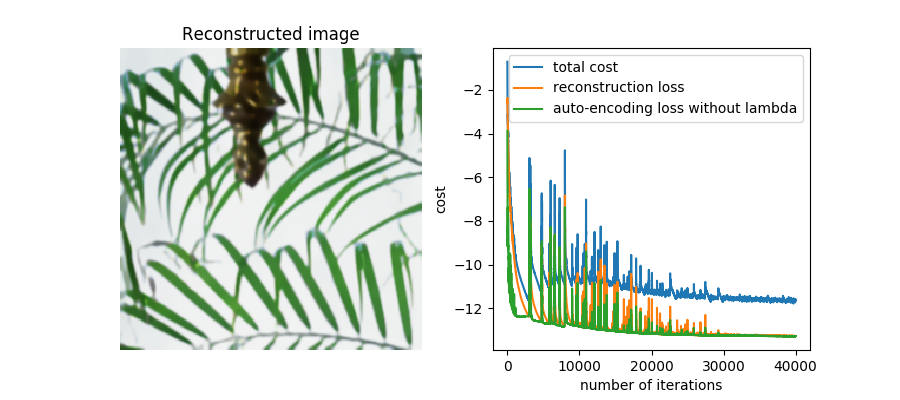

In [5]:
%matplotlib notebook
fig = plt.figure(figsize=(9,4),dpi=100)
ax2 = fig.add_subplot(1,2,1)
ax3 = fig.add_subplot(1,2,2)



In [6]:
import time
import random
import scipy.io

num_iter = 40000
cost_hist = np.zeros([num_iter,3])
psnr_hist = np.zeros([num_iter,1])
start_time = time.time()

sc = 255.0


# reshape
label_data = np.transpose(np.reshape(img.astype(np.float32),[1,N1,N2,N3])/sc)

lam = 20.0 # initial value of lambda (this is adjustable)
with tf.Session(config=config) as sess:
    sess.run(init)
    print('Iinitialized!')
    for step in range(0,num_iter):
        _, cost_value,cost_rec,cost_ae, y_est, x_est = sess.run([update,cost,rec_loss,ae_loss,Yup,X],{label_node:label_data,lam_ph:lam})
        l_rate = sess.run(learning_rate)
        cost_hist[step,0] = cost_value
        cost_hist[step,1] = cost_rec
        cost_hist[step,2] = cost_ae/lam
        yt = np.transpose(np.reshape(255.0*y_est,[3,N2,N1]))
        if step %10 == 0:
            elapsed_time = time.time() - start_time
            start_time   = time.time()
            if cost_rec < cost_ae/lam:
                lam = lam*1.1
            elif cost_ae/lam < cost_rec:
                lam = lam*0.99
            print('Step %d / %d :: %f :: %f :: %f ' % (step,num_iter,cost_value,l_rate,lam))
            ax2.clear()
            ax2.imshow(np.transpose(np.reshape(255.0*y_est,[3,N2,N1])).astype(np.uint8))
            ax2.set_title("Reconstructed image")
            ax2.axis("off")
            ax3.clear()
            ax3.plot(np.log(cost_hist[0:step,0]), label="total cost")
            ax3.plot(np.log(cost_hist[0:step,1]), label="reconstruction loss")
            ax3.plot(np.log(cost_hist[0:step,2]), label="auto-encoding loss without lambda")
            ax3.legend()
            ax3.set_xlabel("number of iterations")
            ax3.set_ylabel("cost")
            fig.canvas.draw()
imageio.imsave('output_DC.png',np.transpose(np.reshape(255.0*y_est,[3,N2,N1])).astype(np.uint8))


Iinitialized!
Step 0 / 40000 :: 0.490059 :: 0.010000 :: 19.800000 
Step 10 / 40000 :: 0.142181 :: 0.010000 :: 19.602000 
Step 20 / 40000 :: 0.090104 :: 0.010000 :: 19.405980 
Step 30 / 40000 :: 0.063082 :: 0.010000 :: 19.211920 
Step 40 / 40000 :: 0.049480 :: 0.010000 :: 19.019801 
Step 50 / 40000 :: 0.042284 :: 0.010000 :: 18.829603 
Step 60 / 40000 :: 0.036236 :: 0.010000 :: 18.641307 
Step 70 / 40000 :: 0.029471 :: 0.010000 :: 18.454894 
Step 80 / 40000 :: 0.023712 :: 0.010000 :: 18.270345 
Step 90 / 40000 :: 0.019598 :: 0.010000 :: 18.087642 
Step 100 / 40000 :: 0.016282 :: 0.010000 :: 17.906765 
Step 110 / 40000 :: 0.017599 :: 0.010000 :: 17.727697 
Step 120 / 40000 :: 0.012208 :: 0.010000 :: 17.550420 
Step 130 / 40000 :: 0.010520 :: 0.010000 :: 17.374916 
Step 140 / 40000 :: 0.008951 :: 0.010000 :: 17.201167 
Step 150 / 40000 :: 0.007831 :: 0.010000 :: 17.029155 
Step 160 / 40000 :: 0.007008 :: 0.010000 :: 16.858864 
Step 170 / 40000 :: 0.006219 :: 0.010000 :: 16.690275 
Step 18

Step 1500 / 40000 :: 0.000036 :: 0.008681 :: 4.384745 
Step 1510 / 40000 :: 0.000035 :: 0.008681 :: 4.340898 
Step 1520 / 40000 :: 0.000035 :: 0.008681 :: 4.297489 
Step 1530 / 40000 :: 0.000034 :: 0.008681 :: 4.254514 
Step 1540 / 40000 :: 0.000034 :: 0.008681 :: 4.211969 
Step 1550 / 40000 :: 0.000033 :: 0.008681 :: 4.169849 
Step 1560 / 40000 :: 0.000033 :: 0.008681 :: 4.128151 
Step 1570 / 40000 :: 0.000033 :: 0.008681 :: 4.086869 
Step 1580 / 40000 :: 0.000032 :: 0.008681 :: 4.046001 
Step 1590 / 40000 :: 0.000032 :: 0.008681 :: 4.005541 
Step 1600 / 40000 :: 0.000031 :: 0.008508 :: 3.965485 
Step 1610 / 40000 :: 0.000031 :: 0.008508 :: 3.925830 
Step 1620 / 40000 :: 0.000031 :: 0.008508 :: 3.886572 
Step 1630 / 40000 :: 0.000030 :: 0.008508 :: 3.847706 
Step 1640 / 40000 :: 0.000030 :: 0.008508 :: 3.809229 
Step 1650 / 40000 :: 0.000030 :: 0.008508 :: 3.771137 
Step 1660 / 40000 :: 0.000029 :: 0.008508 :: 3.733426 
Step 1670 / 40000 :: 0.000029 :: 0.008508 :: 3.696091 
Step 1680 

Step 2990 / 40000 :: 0.000011 :: 0.007536 :: 1.661024 
Step 3000 / 40000 :: 0.000011 :: 0.007386 :: 1.827126 
Step 3010 / 40000 :: 0.000013 :: 0.007386 :: 2.009839 
Step 3020 / 40000 :: 0.001024 :: 0.007386 :: 2.210823 
Step 3030 / 40000 :: 0.000201 :: 0.007386 :: 2.431905 
Step 3040 / 40000 :: 0.000146 :: 0.007386 :: 2.675095 
Step 3050 / 40000 :: 0.000079 :: 0.007386 :: 2.942605 
Step 3060 / 40000 :: 0.000744 :: 0.007386 :: 3.236865 
Step 3070 / 40000 :: 0.001006 :: 0.007386 :: 3.560552 
Step 3080 / 40000 :: 0.000266 :: 0.007386 :: 3.916607 
Step 3090 / 40000 :: 0.000125 :: 0.007386 :: 4.308268 
Step 3100 / 40000 :: 0.000097 :: 0.007386 :: 4.739094 
Step 3110 / 40000 :: 0.001940 :: 0.007386 :: 5.213004 
Step 3120 / 40000 :: 0.000653 :: 0.007386 :: 5.734304 
Step 3130 / 40000 :: 0.000204 :: 0.007386 :: 6.307735 
Step 3140 / 40000 :: 0.000460 :: 0.007386 :: 6.938508 
Step 3150 / 40000 :: 0.000401 :: 0.007386 :: 7.632359 
Step 3160 / 40000 :: 0.000191 :: 0.007386 :: 8.395595 
Step 3170 

Step 4480 / 40000 :: 0.000016 :: 0.006412 :: 3.395683 
Step 4490 / 40000 :: 0.000015 :: 0.006412 :: 3.361726 
Step 4500 / 40000 :: 0.000015 :: 0.006412 :: 3.328109 
Step 4510 / 40000 :: 0.000015 :: 0.006412 :: 3.294828 
Step 4520 / 40000 :: 0.000015 :: 0.006412 :: 3.261879 
Step 4530 / 40000 :: 0.000015 :: 0.006412 :: 3.229261 
Step 4540 / 40000 :: 0.000015 :: 0.006412 :: 3.196968 
Step 4550 / 40000 :: 0.000015 :: 0.006412 :: 3.164998 
Step 4560 / 40000 :: 0.000014 :: 0.006412 :: 3.133348 
Step 4570 / 40000 :: 0.000014 :: 0.006412 :: 3.102015 
Step 4580 / 40000 :: 0.000014 :: 0.006412 :: 3.070995 
Step 4590 / 40000 :: 0.000014 :: 0.006412 :: 3.040285 
Step 4600 / 40000 :: 0.000014 :: 0.006283 :: 3.009882 
Step 4610 / 40000 :: 0.000014 :: 0.006283 :: 2.979783 
Step 4620 / 40000 :: 0.000014 :: 0.006283 :: 2.949985 
Step 4630 / 40000 :: 0.000014 :: 0.006283 :: 2.920485 
Step 4640 / 40000 :: 0.000013 :: 0.006283 :: 2.891281 
Step 4650 / 40000 :: 0.000013 :: 0.006283 :: 2.862368 
Step 4660 

Step 5970 / 40000 :: 0.000020 :: 0.005566 :: 5.622940 
Step 5980 / 40000 :: 0.000020 :: 0.005566 :: 6.185234 
Step 5990 / 40000 :: 0.000027 :: 0.005566 :: 6.803757 
Step 6000 / 40000 :: 0.000106 :: 0.005455 :: 7.484133 
Step 6010 / 40000 :: 0.000674 :: 0.005455 :: 7.409292 
Step 6020 / 40000 :: 0.000161 :: 0.005455 :: 7.335199 
Step 6030 / 40000 :: 0.000113 :: 0.005455 :: 7.261847 
Step 6040 / 40000 :: 0.000067 :: 0.005455 :: 7.189228 
Step 6050 / 40000 :: 0.000042 :: 0.005455 :: 7.117336 
Step 6060 / 40000 :: 0.000040 :: 0.005455 :: 7.046163 
Step 6070 / 40000 :: 0.000036 :: 0.005455 :: 6.975701 
Step 6080 / 40000 :: 0.000031 :: 0.005455 :: 6.905944 
Step 6090 / 40000 :: 0.000029 :: 0.005455 :: 6.836885 
Step 6100 / 40000 :: 0.000028 :: 0.005455 :: 6.768516 
Step 6110 / 40000 :: 0.000028 :: 0.005455 :: 6.700831 
Step 6120 / 40000 :: 0.000027 :: 0.005455 :: 6.633822 
Step 6130 / 40000 :: 0.000026 :: 0.005455 :: 6.567484 
Step 6140 / 40000 :: 0.000026 :: 0.005455 :: 6.501809 
Step 6150 

Step 7460 / 40000 :: 0.000029 :: 0.004735 :: 9.311074 
Step 7470 / 40000 :: 0.000029 :: 0.004735 :: 9.217963 
Step 7480 / 40000 :: 0.000029 :: 0.004735 :: 9.125783 
Step 7490 / 40000 :: 0.000028 :: 0.004735 :: 9.034525 
Step 7500 / 40000 :: 0.000028 :: 0.004735 :: 8.944180 
Step 7510 / 40000 :: 0.000028 :: 0.004735 :: 8.854738 
Step 7520 / 40000 :: 0.000028 :: 0.004735 :: 8.766191 
Step 7530 / 40000 :: 0.000027 :: 0.004735 :: 8.678529 
Step 7540 / 40000 :: 0.000027 :: 0.004735 :: 8.591744 
Step 7550 / 40000 :: 0.000027 :: 0.004735 :: 8.505826 
Step 7560 / 40000 :: 0.000026 :: 0.004735 :: 8.420768 
Step 7570 / 40000 :: 0.000026 :: 0.004735 :: 8.336560 
Step 7580 / 40000 :: 0.000026 :: 0.004735 :: 8.253195 
Step 7590 / 40000 :: 0.000026 :: 0.004735 :: 8.170663 
Step 7600 / 40000 :: 0.000025 :: 0.004641 :: 8.088956 
Step 7610 / 40000 :: 0.000025 :: 0.004641 :: 8.008067 
Step 7620 / 40000 :: 0.000025 :: 0.004641 :: 7.927986 
Step 7630 / 40000 :: 0.000025 :: 0.004641 :: 7.848706 
Step 7640 

Step 8950 / 40000 :: 0.000017 :: 0.004111 :: 5.376024 
Step 8960 / 40000 :: 0.000019 :: 0.004111 :: 5.913626 
Step 8970 / 40000 :: 0.000020 :: 0.004111 :: 6.504989 
Step 8980 / 40000 :: 0.000032 :: 0.004111 :: 7.155487 
Step 8990 / 40000 :: 0.000050 :: 0.004111 :: 7.871036 
Step 9000 / 40000 :: 0.000038 :: 0.004029 :: 8.658140 
Step 9010 / 40000 :: 0.000035 :: 0.004029 :: 9.523954 
Step 9020 / 40000 :: 0.000033 :: 0.004029 :: 9.428714 
Step 9030 / 40000 :: 0.000036 :: 0.004029 :: 9.334427 
Step 9040 / 40000 :: 0.000031 :: 0.004029 :: 9.241083 
Step 9050 / 40000 :: 0.000031 :: 0.004029 :: 9.148672 
Step 9060 / 40000 :: 0.000030 :: 0.004029 :: 9.057185 
Step 9070 / 40000 :: 0.000029 :: 0.004029 :: 8.966613 
Step 9080 / 40000 :: 0.000029 :: 0.004029 :: 8.876947 
Step 9090 / 40000 :: 0.000029 :: 0.004029 :: 8.788178 
Step 9100 / 40000 :: 0.000028 :: 0.004029 :: 8.700296 
Step 9110 / 40000 :: 0.000028 :: 0.004029 :: 8.613293 
Step 9120 / 40000 :: 0.000028 :: 0.004029 :: 8.527160 
Step 9130 

Step 10440 / 40000 :: 0.000035 :: 0.003497 :: 7.210784 
Step 10450 / 40000 :: 0.000025 :: 0.003497 :: 7.138676 
Step 10460 / 40000 :: 0.000022 :: 0.003497 :: 7.067290 
Step 10470 / 40000 :: 0.000022 :: 0.003497 :: 6.996617 
Step 10480 / 40000 :: 0.000021 :: 0.003497 :: 6.926651 
Step 10490 / 40000 :: 0.000021 :: 0.003497 :: 6.857384 
Step 10500 / 40000 :: 0.000020 :: 0.003497 :: 6.788810 
Step 10510 / 40000 :: 0.000020 :: 0.003497 :: 7.467691 
Step 10520 / 40000 :: 0.000023 :: 0.003497 :: 7.393014 
Step 10530 / 40000 :: 0.000033 :: 0.003497 :: 7.319084 
Step 10540 / 40000 :: 0.000025 :: 0.003497 :: 7.245893 
Step 10550 / 40000 :: 0.000021 :: 0.003497 :: 7.970483 
Step 10560 / 40000 :: 0.000077 :: 0.003497 :: 7.890778 
Step 10570 / 40000 :: 0.000034 :: 0.003497 :: 7.811870 
Step 10580 / 40000 :: 0.000026 :: 0.003497 :: 7.733751 
Step 10590 / 40000 :: 0.000023 :: 0.003497 :: 7.656414 
Step 10600 / 40000 :: 0.000023 :: 0.003428 :: 7.579850 
Step 10610 / 40000 :: 0.000022 :: 0.003428 :: 7.

Step 11910 / 40000 :: 0.000024 :: 0.003036 :: 8.881288 
Step 11920 / 40000 :: 0.000024 :: 0.003036 :: 8.792475 
Step 11930 / 40000 :: 0.000024 :: 0.003036 :: 8.704550 
Step 11940 / 40000 :: 0.000024 :: 0.003036 :: 8.617505 
Step 11950 / 40000 :: 0.000023 :: 0.003036 :: 8.531330 
Step 11960 / 40000 :: 0.000023 :: 0.003036 :: 8.446017 
Step 11970 / 40000 :: 0.000023 :: 0.003036 :: 8.361556 
Step 11980 / 40000 :: 0.000023 :: 0.003036 :: 8.277941 
Step 11990 / 40000 :: 0.000023 :: 0.003036 :: 8.195161 
Step 12000 / 40000 :: 0.000022 :: 0.002976 :: 8.113210 
Step 12010 / 40000 :: 0.000022 :: 0.002976 :: 8.032078 
Step 12020 / 40000 :: 0.000022 :: 0.002976 :: 7.951757 
Step 12030 / 40000 :: 0.000022 :: 0.002976 :: 7.872239 
Step 12040 / 40000 :: 0.000022 :: 0.002976 :: 7.793517 
Step 12050 / 40000 :: 0.000021 :: 0.002976 :: 7.715582 
Step 12060 / 40000 :: 0.000021 :: 0.002976 :: 7.638426 
Step 12070 / 40000 :: 0.000021 :: 0.002976 :: 8.402269 
Step 12080 / 40000 :: 0.000023 :: 0.002976 :: 9.

Step 13370 / 40000 :: 0.000019 :: 0.002636 :: 7.249437 
Step 13380 / 40000 :: 0.000019 :: 0.002636 :: 7.176942 
Step 13390 / 40000 :: 0.000019 :: 0.002636 :: 7.105173 
Step 13400 / 40000 :: 0.000019 :: 0.002583 :: 7.034121 
Step 13410 / 40000 :: 0.000018 :: 0.002583 :: 6.963780 
Step 13420 / 40000 :: 0.000018 :: 0.002583 :: 6.894142 
Step 13430 / 40000 :: 0.000018 :: 0.002583 :: 7.583556 
Step 13440 / 40000 :: 0.000020 :: 0.002583 :: 8.341912 
Step 13450 / 40000 :: 0.000021 :: 0.002583 :: 9.176103 
Step 13460 / 40000 :: 0.000023 :: 0.002583 :: 9.084342 
Step 13470 / 40000 :: 0.000061 :: 0.002583 :: 8.993499 
Step 13480 / 40000 :: 0.000030 :: 0.002583 :: 8.903564 
Step 13490 / 40000 :: 0.000028 :: 0.002583 :: 8.814528 
Step 13500 / 40000 :: 0.000023 :: 0.002583 :: 8.726383 
Step 13510 / 40000 :: 0.000023 :: 0.002583 :: 8.639119 
Step 13520 / 40000 :: 0.000022 :: 0.002583 :: 8.552728 
Step 13530 / 40000 :: 0.000022 :: 0.002583 :: 8.467200 
Step 13540 / 40000 :: 0.000022 :: 0.002583 :: 8.

Step 14840 / 40000 :: 0.000018 :: 0.002242 :: 7.232405 
Step 14850 / 40000 :: 0.000018 :: 0.002242 :: 7.160081 
Step 14860 / 40000 :: 0.000018 :: 0.002242 :: 7.876089 
Step 14870 / 40000 :: 0.000032 :: 0.002242 :: 7.797328 
Step 14880 / 40000 :: 0.000029 :: 0.002242 :: 7.719355 
Step 14890 / 40000 :: 0.000024 :: 0.002242 :: 7.642161 
Step 14900 / 40000 :: 0.000021 :: 0.002242 :: 7.565740 
Step 14910 / 40000 :: 0.000019 :: 0.002242 :: 7.490082 
Step 14920 / 40000 :: 0.000019 :: 0.002242 :: 7.415181 
Step 14930 / 40000 :: 0.000018 :: 0.002242 :: 7.341029 
Step 14940 / 40000 :: 0.000018 :: 0.002242 :: 7.267619 
Step 14950 / 40000 :: 0.000018 :: 0.002242 :: 7.194943 
Step 14960 / 40000 :: 0.000018 :: 0.002242 :: 7.122994 
Step 14970 / 40000 :: 0.000018 :: 0.002242 :: 7.051764 
Step 14980 / 40000 :: 0.000018 :: 0.002242 :: 6.981246 
Step 14990 / 40000 :: 0.000017 :: 0.002242 :: 6.911434 
Step 15000 / 40000 :: 0.000017 :: 0.002198 :: 6.842319 
Step 15010 / 40000 :: 0.000017 :: 0.002198 :: 6.

Step 16310 / 40000 :: 0.000017 :: 0.001947 :: 7.215413 
Step 16320 / 40000 :: 0.000017 :: 0.001947 :: 7.143259 
Step 16330 / 40000 :: 0.000017 :: 0.001947 :: 7.071826 
Step 16340 / 40000 :: 0.000017 :: 0.001947 :: 7.001108 
Step 16350 / 40000 :: 0.000017 :: 0.001947 :: 6.931097 
Step 16360 / 40000 :: 0.000017 :: 0.001947 :: 6.861786 
Step 16370 / 40000 :: 0.000016 :: 0.001947 :: 6.793168 
Step 16380 / 40000 :: 0.000016 :: 0.001947 :: 6.725237 
Step 16390 / 40000 :: 0.000016 :: 0.001947 :: 6.657984 
Step 16400 / 40000 :: 0.000016 :: 0.001908 :: 6.591404 
Step 16410 / 40000 :: 0.000016 :: 0.001908 :: 6.525490 
Step 16420 / 40000 :: 0.000016 :: 0.001908 :: 6.460235 
Step 16430 / 40000 :: 0.000016 :: 0.001908 :: 6.395633 
Step 16440 / 40000 :: 0.000015 :: 0.001908 :: 6.331677 
Step 16450 / 40000 :: 0.000015 :: 0.001908 :: 6.268360 
Step 16460 / 40000 :: 0.000015 :: 0.001908 :: 6.205676 
Step 16470 / 40000 :: 0.000015 :: 0.001908 :: 6.143620 
Step 16480 / 40000 :: 0.000015 :: 0.001908 :: 6.

Step 17780 / 40000 :: 0.000014 :: 0.001690 :: 5.830754 
Step 17790 / 40000 :: 0.000014 :: 0.001690 :: 5.772446 
Step 17800 / 40000 :: 0.000014 :: 0.001656 :: 5.714722 
Step 17810 / 40000 :: 0.000013 :: 0.001656 :: 5.657574 
Step 17820 / 40000 :: 0.000013 :: 0.001656 :: 5.600999 
Step 17830 / 40000 :: 0.000013 :: 0.001656 :: 5.544989 
Step 17840 / 40000 :: 0.000013 :: 0.001656 :: 6.099488 
Step 17850 / 40000 :: 0.000014 :: 0.001656 :: 6.709436 
Step 17860 / 40000 :: 0.000061 :: 0.001656 :: 6.642342 
Step 17870 / 40000 :: 0.000019 :: 0.001656 :: 7.306576 
Step 17880 / 40000 :: 0.000020 :: 0.001656 :: 7.233510 
Step 17890 / 40000 :: 0.000017 :: 0.001656 :: 7.161175 
Step 17900 / 40000 :: 0.000017 :: 0.001656 :: 7.089564 
Step 17910 / 40000 :: 0.000016 :: 0.001656 :: 7.018668 
Step 17920 / 40000 :: 0.000016 :: 0.001656 :: 6.948481 
Step 17930 / 40000 :: 0.000016 :: 0.001656 :: 6.878996 
Step 17940 / 40000 :: 0.000016 :: 0.001656 :: 6.810206 
Step 17950 / 40000 :: 0.000016 :: 0.001656 :: 6.

Step 19250 / 40000 :: 0.000015 :: 0.001438 :: 6.463394 
Step 19260 / 40000 :: 0.000015 :: 0.001438 :: 6.398760 
Step 19270 / 40000 :: 0.000014 :: 0.001438 :: 6.334773 
Step 19280 / 40000 :: 0.000014 :: 0.001438 :: 6.271425 
Step 19290 / 40000 :: 0.000014 :: 0.001438 :: 6.208711 
Step 19300 / 40000 :: 0.000014 :: 0.001438 :: 6.146624 
Step 19310 / 40000 :: 0.000014 :: 0.001438 :: 6.085158 
Step 19320 / 40000 :: 0.000014 :: 0.001438 :: 6.024306 
Step 19330 / 40000 :: 0.000014 :: 0.001438 :: 5.964063 
Step 19340 / 40000 :: 0.000014 :: 0.001438 :: 5.904422 
Step 19350 / 40000 :: 0.000013 :: 0.001438 :: 5.845378 
Step 19360 / 40000 :: 0.000013 :: 0.001438 :: 5.786924 
Step 19370 / 40000 :: 0.000013 :: 0.001438 :: 5.729055 
Step 19380 / 40000 :: 0.000013 :: 0.001438 :: 5.671764 
Step 19390 / 40000 :: 0.000013 :: 0.001438 :: 5.615047 
Step 19400 / 40000 :: 0.000013 :: 0.001409 :: 5.558896 
Step 19410 / 40000 :: 0.000013 :: 0.001409 :: 5.503307 
Step 19420 / 40000 :: 0.000013 :: 0.001409 :: 5.

Step 20720 / 40000 :: 0.000012 :: 0.001248 :: 5.223050 
Step 20730 / 40000 :: 0.000012 :: 0.001248 :: 5.170819 
Step 20740 / 40000 :: 0.000012 :: 0.001248 :: 5.119111 
Step 20750 / 40000 :: 0.000012 :: 0.001248 :: 5.631022 
Step 20760 / 40000 :: 0.000019 :: 0.001248 :: 5.574712 
Step 20770 / 40000 :: 0.000014 :: 0.001248 :: 5.518965 
Step 20780 / 40000 :: 0.000014 :: 0.001248 :: 5.463775 
Step 20790 / 40000 :: 0.000013 :: 0.001248 :: 5.409137 
Step 20800 / 40000 :: 0.000012 :: 0.001223 :: 5.355046 
Step 20810 / 40000 :: 0.000012 :: 0.001223 :: 5.301495 
Step 20820 / 40000 :: 0.000012 :: 0.001223 :: 5.248480 
Step 20830 / 40000 :: 0.000012 :: 0.001223 :: 5.773329 
Step 20840 / 40000 :: 0.000013 :: 0.001223 :: 6.350661 
Step 20850 / 40000 :: 0.000015 :: 0.001223 :: 6.287155 
Step 20860 / 40000 :: 0.000014 :: 0.001223 :: 6.224283 
Step 20870 / 40000 :: 0.000014 :: 0.001223 :: 6.162040 
Step 20880 / 40000 :: 0.000014 :: 0.001223 :: 6.100420 
Step 20890 / 40000 :: 0.000014 :: 0.001223 :: 6.

Step 22190 / 40000 :: 0.000012 :: 0.001084 :: 5.210779 
Step 22200 / 40000 :: 0.000012 :: 0.001062 :: 5.158671 
Step 22210 / 40000 :: 0.000012 :: 0.001062 :: 5.107084 
Step 22220 / 40000 :: 0.000012 :: 0.001062 :: 5.056013 
Step 22230 / 40000 :: 0.000011 :: 0.001062 :: 5.005453 
Step 22240 / 40000 :: 0.000011 :: 0.001062 :: 5.505998 
Step 22250 / 40000 :: 0.000012 :: 0.001062 :: 5.450938 
Step 22260 / 40000 :: 0.000012 :: 0.001062 :: 5.396429 
Step 22270 / 40000 :: 0.000012 :: 0.001062 :: 5.342465 
Step 22280 / 40000 :: 0.000012 :: 0.001062 :: 5.289040 
Step 22290 / 40000 :: 0.000012 :: 0.001062 :: 5.236150 
Step 22300 / 40000 :: 0.000012 :: 0.001062 :: 5.183788 
Step 22310 / 40000 :: 0.000012 :: 0.001062 :: 5.131950 
Step 22320 / 40000 :: 0.000012 :: 0.001062 :: 5.080631 
Step 22330 / 40000 :: 0.000012 :: 0.001062 :: 5.029825 
Step 22340 / 40000 :: 0.000011 :: 0.001062 :: 4.979526 
Step 22350 / 40000 :: 0.000011 :: 0.001062 :: 4.929731 
Step 22360 / 40000 :: 0.000011 :: 0.001062 :: 4.

Step 23660 / 40000 :: 0.000012 :: 0.000922 :: 5.198536 
Step 23670 / 40000 :: 0.000011 :: 0.000922 :: 5.718390 
Step 23680 / 40000 :: 0.000013 :: 0.000922 :: 5.661206 
Step 23690 / 40000 :: 0.000013 :: 0.000922 :: 5.604594 
Step 23700 / 40000 :: 0.000012 :: 0.000922 :: 5.548548 
Step 23710 / 40000 :: 0.000012 :: 0.000922 :: 5.493063 
Step 23720 / 40000 :: 0.000012 :: 0.000922 :: 5.438132 
Step 23730 / 40000 :: 0.000012 :: 0.000922 :: 5.383751 
Step 23740 / 40000 :: 0.000012 :: 0.000922 :: 5.329913 
Step 23750 / 40000 :: 0.000012 :: 0.000922 :: 5.276614 
Step 23760 / 40000 :: 0.000012 :: 0.000922 :: 5.223848 
Step 23770 / 40000 :: 0.000012 :: 0.000922 :: 5.171610 
Step 23780 / 40000 :: 0.000011 :: 0.000922 :: 5.119893 
Step 23790 / 40000 :: 0.000011 :: 0.000922 :: 5.068695 
Step 23800 / 40000 :: 0.000011 :: 0.000903 :: 5.018008 
Step 23810 / 40000 :: 0.000011 :: 0.000903 :: 4.967827 
Step 23820 / 40000 :: 0.000011 :: 0.000903 :: 4.918149 
Step 23830 / 40000 :: 0.000011 :: 0.000903 :: 4.

Step 25130 / 40000 :: 0.000011 :: 0.000800 :: 5.186323 
Step 25140 / 40000 :: 0.000011 :: 0.000800 :: 5.134460 
Step 25150 / 40000 :: 0.000011 :: 0.000800 :: 5.083115 
Step 25160 / 40000 :: 0.000011 :: 0.000800 :: 5.032284 
Step 25170 / 40000 :: 0.000011 :: 0.000800 :: 4.981961 
Step 25180 / 40000 :: 0.000011 :: 0.000800 :: 4.932142 
Step 25190 / 40000 :: 0.000011 :: 0.000800 :: 4.882820 
Step 25200 / 40000 :: 0.000011 :: 0.000784 :: 4.833992 
Step 25210 / 40000 :: 0.000011 :: 0.000784 :: 4.785652 
Step 25220 / 40000 :: 0.000011 :: 0.000784 :: 4.737796 
Step 25230 / 40000 :: 0.000010 :: 0.000784 :: 4.690418 
Step 25240 / 40000 :: 0.000010 :: 0.000784 :: 4.643513 
Step 25250 / 40000 :: 0.000010 :: 0.000784 :: 4.597078 
Step 25260 / 40000 :: 0.000010 :: 0.000784 :: 4.551108 
Step 25270 / 40000 :: 0.000010 :: 0.000784 :: 5.006218 
Step 25280 / 40000 :: 0.000011 :: 0.000784 :: 4.956156 
Step 25290 / 40000 :: 0.000011 :: 0.000784 :: 4.906595 
Step 25300 / 40000 :: 0.000011 :: 0.000784 :: 4.

Step 26600 / 40000 :: 0.000010 :: 0.000681 :: 4.656725 
Step 26610 / 40000 :: 0.000010 :: 0.000681 :: 4.610157 
Step 26620 / 40000 :: 0.000010 :: 0.000681 :: 4.564056 
Step 26630 / 40000 :: 0.000010 :: 0.000681 :: 4.518415 
Step 26640 / 40000 :: 0.000010 :: 0.000681 :: 4.473231 
Step 26650 / 40000 :: 0.000010 :: 0.000681 :: 4.428499 
Step 26660 / 40000 :: 0.000010 :: 0.000681 :: 4.384214 
Step 26670 / 40000 :: 0.000010 :: 0.000681 :: 4.340372 
Step 26680 / 40000 :: 0.000010 :: 0.000681 :: 4.774409 
Step 26690 / 40000 :: 0.000010 :: 0.000681 :: 4.726665 
Step 26700 / 40000 :: 0.000010 :: 0.000681 :: 4.679398 
Step 26710 / 40000 :: 0.000010 :: 0.000681 :: 4.632604 
Step 26720 / 40000 :: 0.000010 :: 0.000681 :: 4.586278 
Step 26730 / 40000 :: 0.000010 :: 0.000681 :: 4.540415 
Step 26740 / 40000 :: 0.000010 :: 0.000681 :: 4.495011 
Step 26750 / 40000 :: 0.000010 :: 0.000681 :: 4.450061 
Step 26760 / 40000 :: 0.000010 :: 0.000681 :: 4.405560 
Step 26770 / 40000 :: 0.000010 :: 0.000681 :: 4.

Step 28070 / 40000 :: 0.000009 :: 0.000591 :: 4.181206 
Step 28080 / 40000 :: 0.000009 :: 0.000591 :: 4.139394 
Step 28090 / 40000 :: 0.000009 :: 0.000591 :: 4.098000 
Step 28100 / 40000 :: 0.000009 :: 0.000591 :: 4.057020 
Step 28110 / 40000 :: 0.000009 :: 0.000591 :: 4.016450 
Step 28120 / 40000 :: 0.000009 :: 0.000591 :: 3.976285 
Step 28130 / 40000 :: 0.000009 :: 0.000591 :: 3.936522 
Step 28140 / 40000 :: 0.000009 :: 0.000591 :: 3.897157 
Step 28150 / 40000 :: 0.000009 :: 0.000591 :: 3.858185 
Step 28160 / 40000 :: 0.000009 :: 0.000591 :: 3.819604 
Step 28170 / 40000 :: 0.000009 :: 0.000591 :: 3.781408 
Step 28180 / 40000 :: 0.000009 :: 0.000591 :: 3.743593 
Step 28190 / 40000 :: 0.000009 :: 0.000591 :: 3.706158 
Step 28200 / 40000 :: 0.000008 :: 0.000579 :: 3.669096 
Step 28210 / 40000 :: 0.000008 :: 0.000579 :: 4.036006 
Step 28220 / 40000 :: 0.000009 :: 0.000579 :: 4.439606 
Step 28230 / 40000 :: 0.000010 :: 0.000579 :: 4.395210 
Step 28240 / 40000 :: 0.000010 :: 0.000579 :: 4.

Step 29540 / 40000 :: 0.000011 :: 0.000513 :: 5.149855 
Step 29550 / 40000 :: 0.000011 :: 0.000513 :: 5.098356 
Step 29560 / 40000 :: 0.000011 :: 0.000513 :: 5.047373 
Step 29570 / 40000 :: 0.000011 :: 0.000513 :: 4.996899 
Step 29580 / 40000 :: 0.000011 :: 0.000513 :: 4.946930 
Step 29590 / 40000 :: 0.000011 :: 0.000513 :: 4.897461 
Step 29600 / 40000 :: 0.000011 :: 0.000503 :: 4.848486 
Step 29610 / 40000 :: 0.000010 :: 0.000503 :: 4.800001 
Step 29620 / 40000 :: 0.000010 :: 0.000503 :: 4.752001 
Step 29630 / 40000 :: 0.000010 :: 0.000503 :: 4.704481 
Step 29640 / 40000 :: 0.000010 :: 0.000503 :: 4.657436 
Step 29650 / 40000 :: 0.000010 :: 0.000503 :: 4.610862 
Step 29660 / 40000 :: 0.000010 :: 0.000503 :: 4.564753 
Step 29670 / 40000 :: 0.000010 :: 0.000503 :: 4.519106 
Step 29680 / 40000 :: 0.000010 :: 0.000503 :: 4.473915 
Step 29690 / 40000 :: 0.000010 :: 0.000503 :: 4.429176 
Step 29700 / 40000 :: 0.000010 :: 0.000503 :: 4.384884 
Step 29710 / 40000 :: 0.000010 :: 0.000503 :: 4.

Step 31010 / 40000 :: 0.000010 :: 0.000437 :: 4.623980 
Step 31020 / 40000 :: 0.000010 :: 0.000437 :: 4.577740 
Step 31030 / 40000 :: 0.000010 :: 0.000437 :: 4.531963 
Step 31040 / 40000 :: 0.000010 :: 0.000437 :: 4.486643 
Step 31050 / 40000 :: 0.000010 :: 0.000437 :: 4.441777 
Step 31060 / 40000 :: 0.000010 :: 0.000437 :: 4.397359 
Step 31070 / 40000 :: 0.000010 :: 0.000437 :: 4.353386 
Step 31080 / 40000 :: 0.000010 :: 0.000437 :: 4.309852 
Step 31090 / 40000 :: 0.000009 :: 0.000437 :: 4.266753 
Step 31100 / 40000 :: 0.000009 :: 0.000437 :: 4.224086 
Step 31110 / 40000 :: 0.000009 :: 0.000437 :: 4.181845 
Step 31120 / 40000 :: 0.000009 :: 0.000437 :: 4.140026 
Step 31130 / 40000 :: 0.000009 :: 0.000437 :: 4.098626 
Step 31140 / 40000 :: 0.000009 :: 0.000437 :: 4.057640 
Step 31150 / 40000 :: 0.000009 :: 0.000437 :: 4.017064 
Step 31160 / 40000 :: 0.000009 :: 0.000437 :: 4.418770 
Step 31170 / 40000 :: 0.000010 :: 0.000437 :: 4.374582 
Step 31180 / 40000 :: 0.000010 :: 0.000437 :: 4.

Step 32480 / 40000 :: 0.000009 :: 0.000379 :: 4.151805 
Step 32490 / 40000 :: 0.000009 :: 0.000379 :: 4.110287 
Step 32500 / 40000 :: 0.000009 :: 0.000379 :: 4.069184 
Step 32510 / 40000 :: 0.000009 :: 0.000379 :: 4.028492 
Step 32520 / 40000 :: 0.000009 :: 0.000379 :: 3.988207 
Step 32530 / 40000 :: 0.000009 :: 0.000379 :: 3.948325 
Step 32540 / 40000 :: 0.000009 :: 0.000379 :: 3.908842 
Step 32550 / 40000 :: 0.000009 :: 0.000379 :: 3.869754 
Step 32560 / 40000 :: 0.000009 :: 0.000379 :: 3.831056 
Step 32570 / 40000 :: 0.000009 :: 0.000379 :: 3.792746 
Step 32580 / 40000 :: 0.000008 :: 0.000379 :: 4.172020 
Step 32590 / 40000 :: 0.000009 :: 0.000379 :: 4.589222 
Step 32600 / 40000 :: 0.000010 :: 0.000371 :: 4.543330 
Step 32610 / 40000 :: 0.000010 :: 0.000371 :: 4.497897 
Step 32620 / 40000 :: 0.000010 :: 0.000371 :: 4.947686 
Step 32630 / 40000 :: 0.000010 :: 0.000371 :: 4.898209 
Step 32640 / 40000 :: 0.000010 :: 0.000371 :: 4.849227 
Step 32650 / 40000 :: 0.000010 :: 0.000371 :: 4.

Step 33950 / 40000 :: 0.000009 :: 0.000329 :: 4.142051 
Step 33960 / 40000 :: 0.000009 :: 0.000329 :: 4.100630 
Step 33970 / 40000 :: 0.000009 :: 0.000329 :: 4.059624 
Step 33980 / 40000 :: 0.000009 :: 0.000329 :: 4.019028 
Step 33990 / 40000 :: 0.000009 :: 0.000329 :: 3.978838 
Step 34000 / 40000 :: 0.000009 :: 0.000322 :: 4.376721 
Step 34010 / 40000 :: 0.000009 :: 0.000322 :: 4.332954 
Step 34020 / 40000 :: 0.000009 :: 0.000322 :: 4.289625 
Step 34030 / 40000 :: 0.000009 :: 0.000322 :: 4.246728 
Step 34040 / 40000 :: 0.000009 :: 0.000322 :: 4.204261 
Step 34050 / 40000 :: 0.000009 :: 0.000322 :: 4.624687 
Step 34060 / 40000 :: 0.000010 :: 0.000322 :: 4.578440 
Step 34070 / 40000 :: 0.000010 :: 0.000322 :: 4.532656 
Step 34080 / 40000 :: 0.000010 :: 0.000322 :: 4.487329 
Step 34090 / 40000 :: 0.000010 :: 0.000322 :: 4.442456 
Step 34100 / 40000 :: 0.000010 :: 0.000322 :: 4.398031 
Step 34110 / 40000 :: 0.000009 :: 0.000322 :: 4.354051 
Step 34120 / 40000 :: 0.000009 :: 0.000322 :: 4.

Step 35420 / 40000 :: 0.000009 :: 0.000280 :: 4.132320 
Step 35430 / 40000 :: 0.000009 :: 0.000280 :: 4.090996 
Step 35440 / 40000 :: 0.000009 :: 0.000280 :: 4.050086 
Step 35450 / 40000 :: 0.000009 :: 0.000280 :: 4.009586 
Step 35460 / 40000 :: 0.000009 :: 0.000280 :: 3.969490 
Step 35470 / 40000 :: 0.000009 :: 0.000280 :: 3.929795 
Step 35480 / 40000 :: 0.000009 :: 0.000280 :: 3.890497 
Step 35490 / 40000 :: 0.000009 :: 0.000280 :: 3.851592 
Step 35500 / 40000 :: 0.000008 :: 0.000280 :: 3.813076 
Step 35510 / 40000 :: 0.000008 :: 0.000280 :: 4.194384 
Step 35520 / 40000 :: 0.000009 :: 0.000280 :: 4.613822 
Step 35530 / 40000 :: 0.000010 :: 0.000280 :: 4.567684 
Step 35540 / 40000 :: 0.000010 :: 0.000280 :: 4.522007 
Step 35550 / 40000 :: 0.000010 :: 0.000280 :: 4.476787 
Step 35560 / 40000 :: 0.000010 :: 0.000280 :: 4.432019 
Step 35570 / 40000 :: 0.000009 :: 0.000280 :: 4.387699 
Step 35580 / 40000 :: 0.000009 :: 0.000280 :: 4.343822 
Step 35590 / 40000 :: 0.000009 :: 0.000280 :: 4.

Step 36890 / 40000 :: 0.000008 :: 0.000243 :: 3.710350 
Step 36900 / 40000 :: 0.000008 :: 0.000243 :: 4.081385 
Step 36910 / 40000 :: 0.000009 :: 0.000243 :: 4.040571 
Step 36920 / 40000 :: 0.000009 :: 0.000243 :: 4.000166 
Step 36930 / 40000 :: 0.000009 :: 0.000243 :: 3.960164 
Step 36940 / 40000 :: 0.000009 :: 0.000243 :: 3.920562 
Step 36950 / 40000 :: 0.000009 :: 0.000243 :: 3.881357 
Step 36960 / 40000 :: 0.000008 :: 0.000243 :: 4.269492 
Step 36970 / 40000 :: 0.000009 :: 0.000243 :: 4.226797 
Step 36980 / 40000 :: 0.000009 :: 0.000243 :: 4.649477 
Step 36990 / 40000 :: 0.000010 :: 0.000243 :: 4.602982 
Step 37000 / 40000 :: 0.000010 :: 0.000238 :: 4.556952 
Step 37010 / 40000 :: 0.000010 :: 0.000238 :: 4.511383 
Step 37020 / 40000 :: 0.000010 :: 0.000238 :: 4.466269 
Step 37030 / 40000 :: 0.000009 :: 0.000238 :: 4.421606 
Step 37040 / 40000 :: 0.000009 :: 0.000238 :: 4.377390 
Step 37050 / 40000 :: 0.000009 :: 0.000238 :: 4.333616 
Step 37060 / 40000 :: 0.000009 :: 0.000238 :: 4.

Step 38360 / 40000 :: 0.000010 :: 0.000211 :: 4.569917 
Step 38370 / 40000 :: 0.000010 :: 0.000211 :: 4.524218 
Step 38380 / 40000 :: 0.000010 :: 0.000211 :: 4.478976 
Step 38390 / 40000 :: 0.000009 :: 0.000211 :: 4.434186 
Step 38400 / 40000 :: 0.000009 :: 0.000207 :: 4.389844 
Step 38410 / 40000 :: 0.000009 :: 0.000207 :: 4.345946 
Step 38420 / 40000 :: 0.000009 :: 0.000207 :: 4.302486 
Step 38430 / 40000 :: 0.000009 :: 0.000207 :: 4.259462 
Step 38440 / 40000 :: 0.000009 :: 0.000207 :: 4.216867 
Step 38450 / 40000 :: 0.000009 :: 0.000207 :: 4.174698 
Step 38460 / 40000 :: 0.000009 :: 0.000207 :: 4.132951 
Step 38470 / 40000 :: 0.000009 :: 0.000207 :: 4.091622 
Step 38480 / 40000 :: 0.000009 :: 0.000207 :: 4.050706 
Step 38490 / 40000 :: 0.000009 :: 0.000207 :: 4.010199 
Step 38500 / 40000 :: 0.000009 :: 0.000207 :: 3.970097 
Step 38510 / 40000 :: 0.000009 :: 0.000207 :: 3.930396 
Step 38520 / 40000 :: 0.000009 :: 0.000207 :: 3.891092 
Step 38530 / 40000 :: 0.000008 :: 0.000207 :: 3.

Step 39830 / 40000 :: 0.000009 :: 0.000179 :: 4.103263 
Step 39840 / 40000 :: 0.000009 :: 0.000179 :: 4.062230 
Step 39850 / 40000 :: 0.000009 :: 0.000179 :: 4.021608 
Step 39860 / 40000 :: 0.000009 :: 0.000179 :: 3.981392 
Step 39870 / 40000 :: 0.000009 :: 0.000179 :: 3.941578 
Step 39880 / 40000 :: 0.000009 :: 0.000179 :: 3.902162 
Step 39890 / 40000 :: 0.000008 :: 0.000179 :: 3.863140 
Step 39900 / 40000 :: 0.000008 :: 0.000179 :: 3.824509 
Step 39910 / 40000 :: 0.000008 :: 0.000179 :: 3.786264 
Step 39920 / 40000 :: 0.000008 :: 0.000179 :: 3.748401 
Step 39930 / 40000 :: 0.000008 :: 0.000179 :: 3.710917 
Step 39940 / 40000 :: 0.000008 :: 0.000179 :: 4.082009 
Step 39950 / 40000 :: 0.000009 :: 0.000179 :: 4.041189 
Step 39960 / 40000 :: 0.000009 :: 0.000179 :: 4.000777 
Step 39970 / 40000 :: 0.000009 :: 0.000179 :: 4.400855 
Step 39980 / 40000 :: 0.000009 :: 0.000179 :: 4.356846 
Step 39990 / 40000 :: 0.000009 :: 0.000179 :: 4.313278 
